- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

## To-do:

- Post-processing step snapping nearby nodes together. In case of clusters, do that iteratively.


In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
from libpysal import graph
from scipy import sparse

from core import algorithms, utils


In [2]:
# logging.basicConfig(level=logging.DEBUG)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_parquet_roads(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Assign COINS-based information to roads

In [6]:
# %%time
roads, coins = algorithms.common.continuity(roads)

Read artifacts

In [7]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [8]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Get nodes from the network.

In [9]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

Link nodes to artifacts

In [10]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Compute number of nodes per artifact

In [11]:
artifacts["node_count"] = intersects.sum(axis=0)

Apply additional filters to remove artifacts that are not suitable for simplification. These may be artifacts that:
- are too large in size
- are part of a larger intersection that may need different methods of simplification

In [12]:
area_threshold = 1250  # this is hard to determine but it can be done iteratively using different thresholds
circular_compactness_threshold = 0.15  # same as above

rook = graph.Graph.build_contiguity(artifacts, rook=True)

# keep only those artifacts which occur as isolates, i.e. are not part of a larger intersection
artifacts = artifacts.loc[artifacts.index.intersection(rook.isolates)]

Compute number of stroke groups per artifact

In [13]:
strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

artifacts["stroke_count"] = strokes
artifacts["C"] = c_
artifacts["E"] = e_
artifacts["S"] = s_

Filter artifacts caused by non-planar intersections. (Note that this is not perfect and some 3CC artifacts were non-planar but not captured here).

In [14]:
artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
a_idx, r_idx = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
artifacts.iloc[np.unique(a_idx), -1] = True

Count intersititial nodes (primes).

In [15]:
artifacts["interstitial_nodes"] = artifacts.node_count - artifacts[["C", "E", "S"]].sum(
    axis=1
)

Define the type label.

In [16]:
ces_type = []
for x in artifacts[["node_count", "C", "E", "S"]].itertuples():
    ces_type.append(f"{x.node_count}{'C' * x.C}{'E' * x.E}{'S' * x.S}")
artifacts["ces_type"] = ces_type

Explore typology.

In [17]:
# ces = "3CC"
#
# m = roads.explore(
#     "coins_len",
#     k=20,
#     scheme="quantiles",
#     tiles="cartodb positron",
#     prefer_canvas=True,
#     name="Roads",
#     highlight_kwds={"color": "red"},
#     style_kwds=dict(weight=5),
#     max_zoom=52,
#     opacity=0.5,
# )
# artifacts[artifacts.ces_type == ces].explore(m=m, name="Artifacts", color="red")
# nodes.explore(m=m, name="Nodes", color="blue", marker_size=250)
# folium.LayerControl().add_to(m)
# plugins.MousePosition().add_to(m)

# m

Optionally define a subset of data.

In [18]:
data_sample = artifacts.sample(50)

Simplify singleton artifacts.

In [19]:
new_roads = algorithms.simplify.simplify_singletons(data_sample, roads, nodes)

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

Visual exploration of the result.

4640


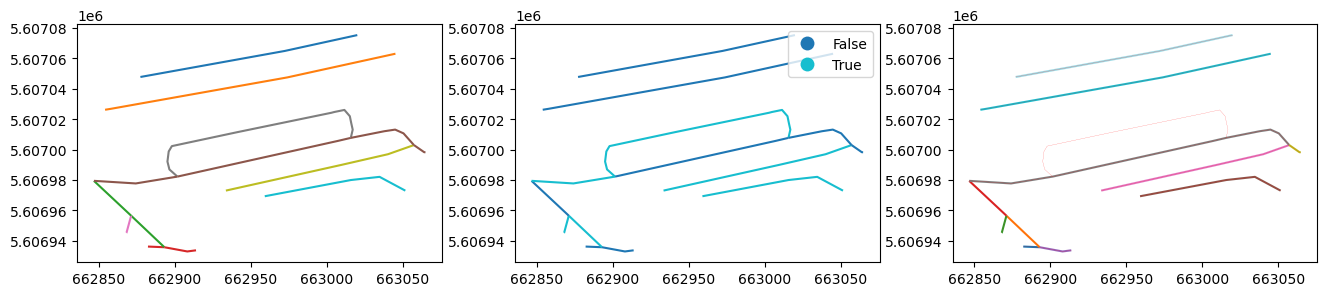

2277


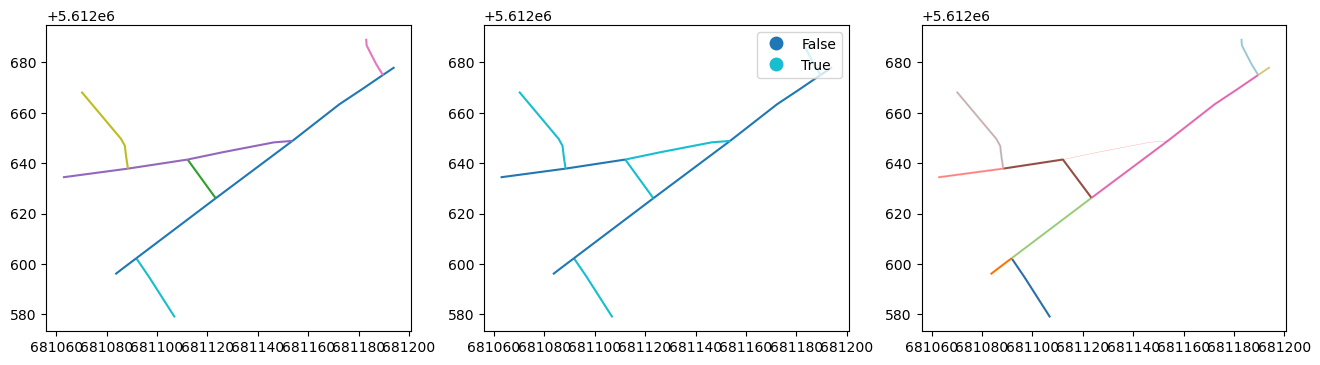

188


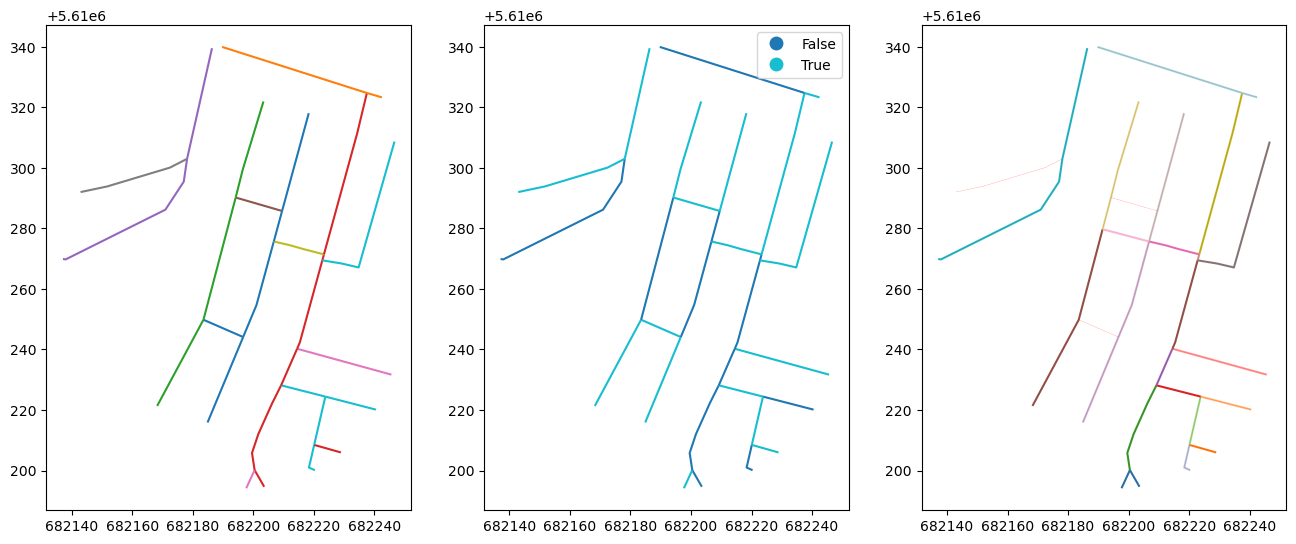

6840


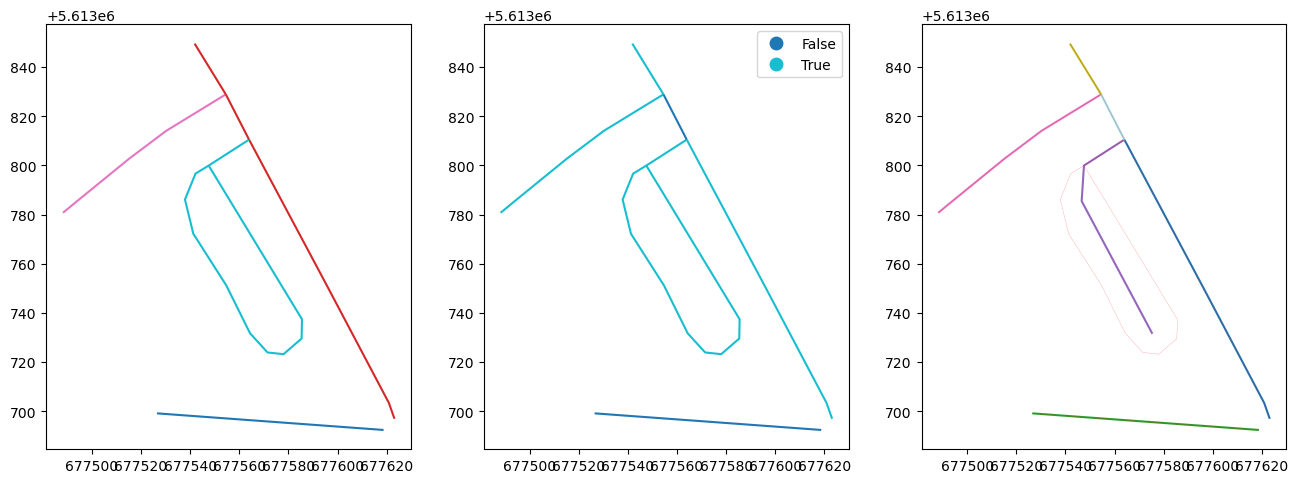

6063


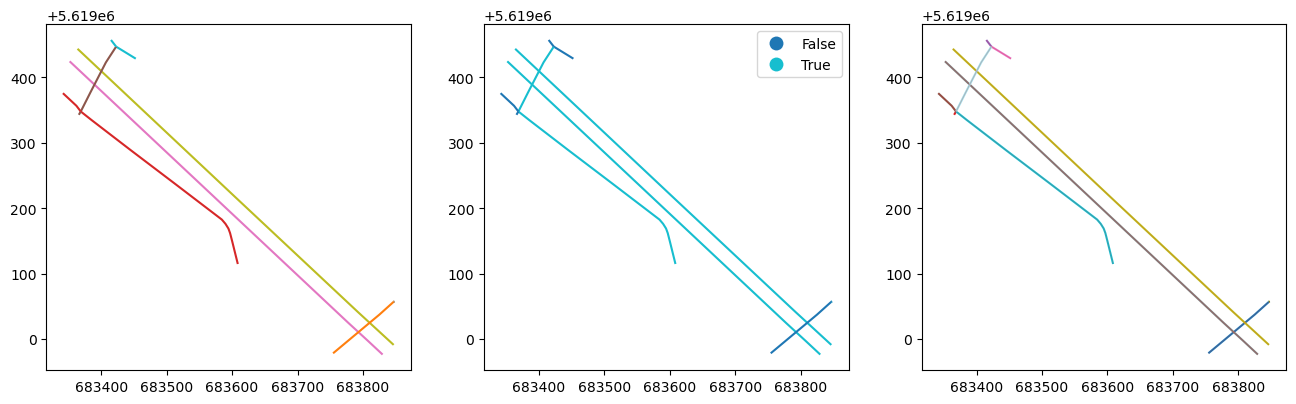

2392


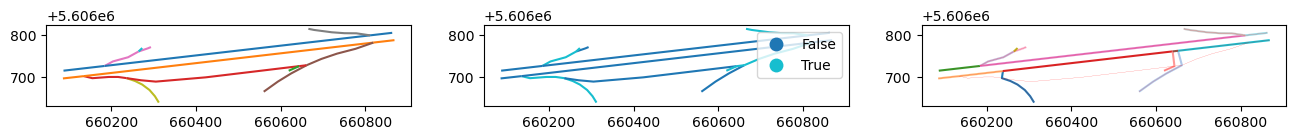

6300


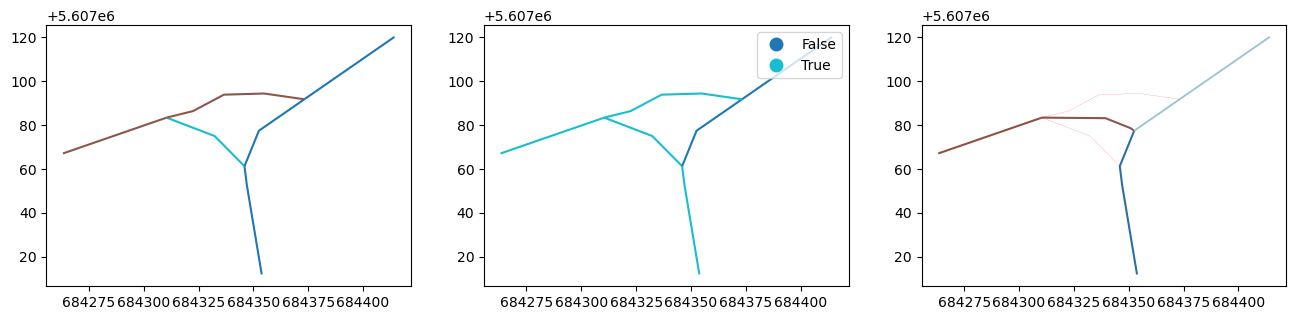

4575


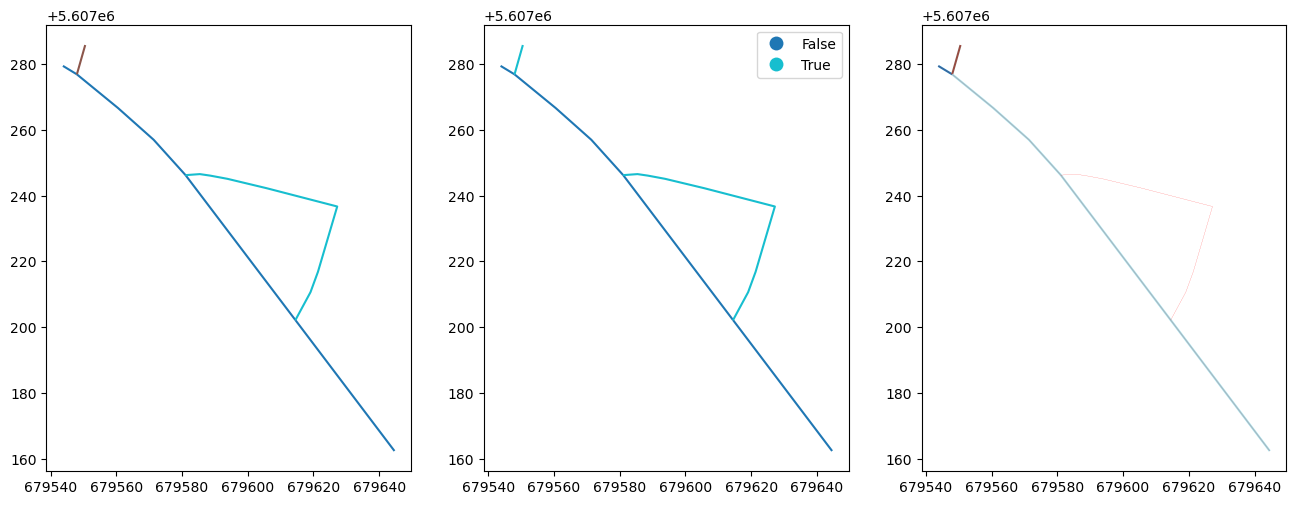

6824


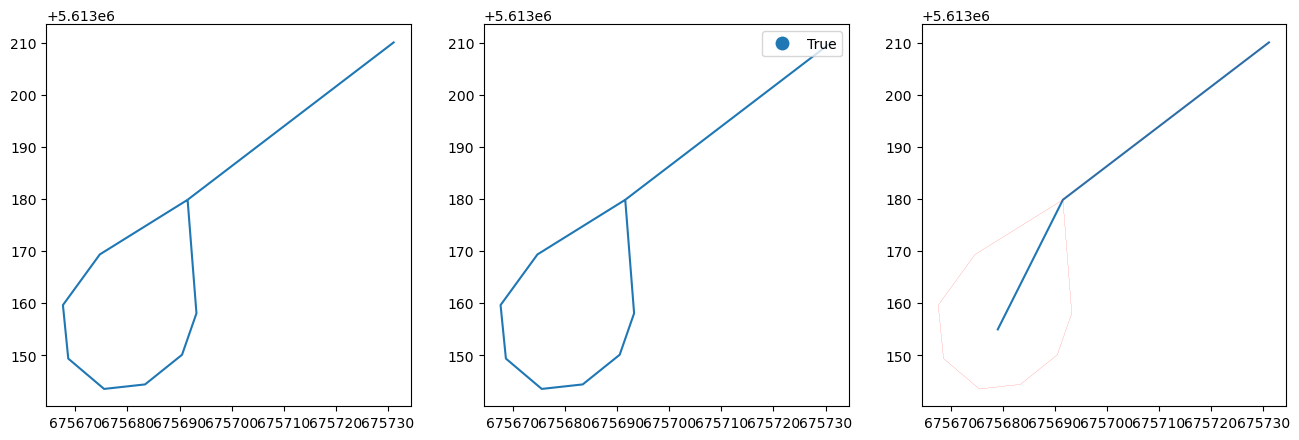

3348


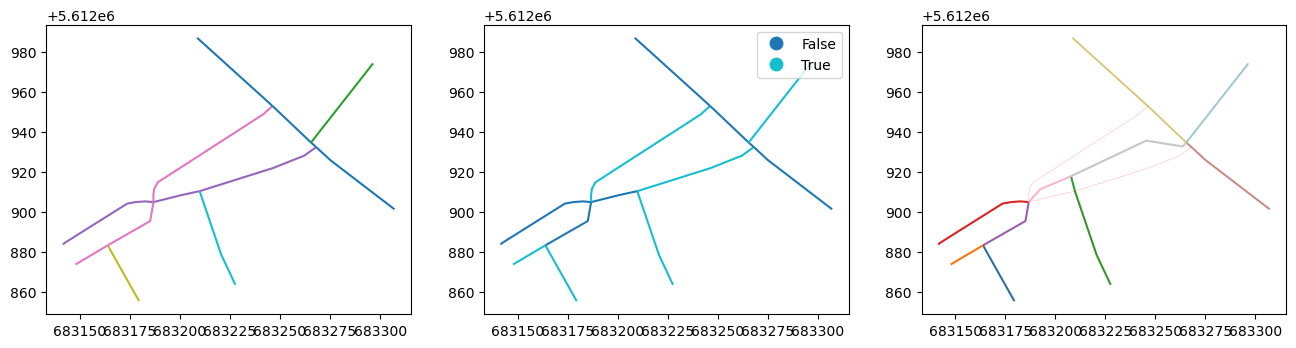

3790


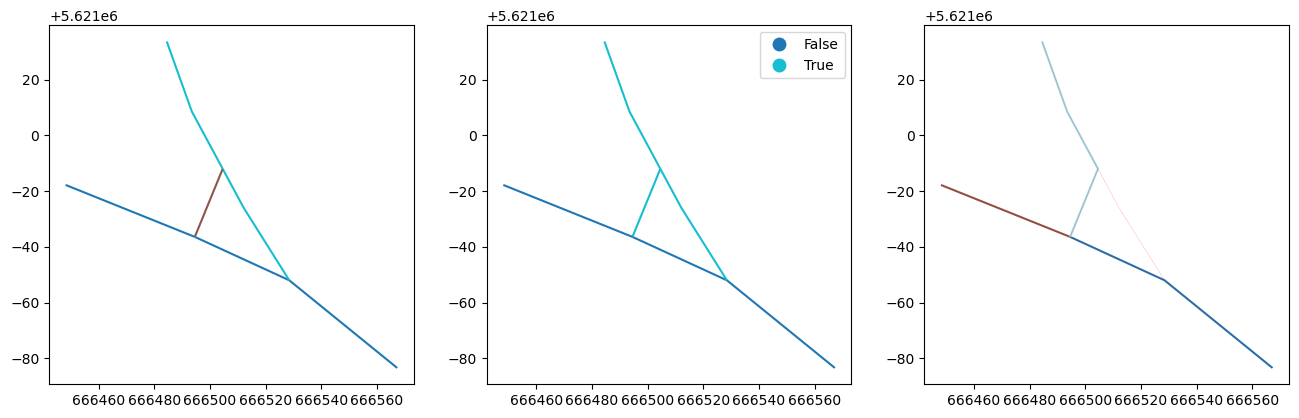

1247


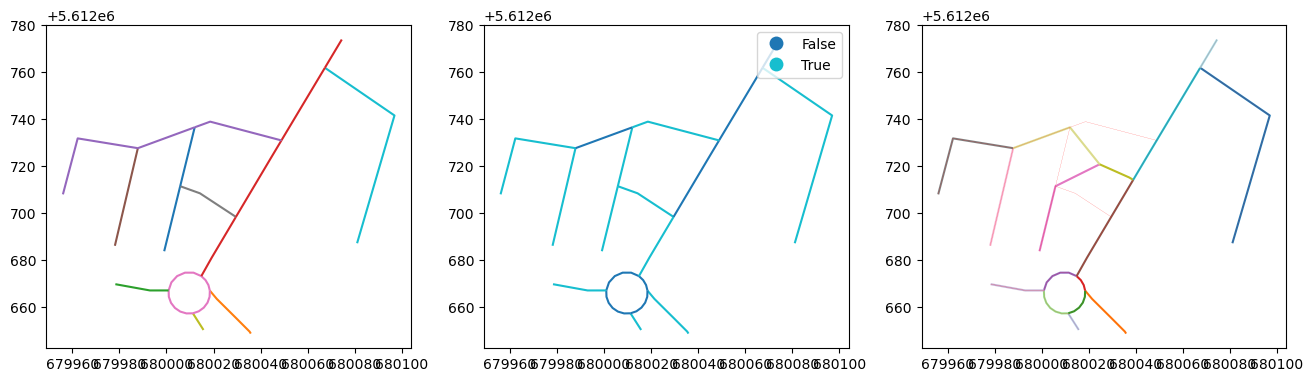

3852


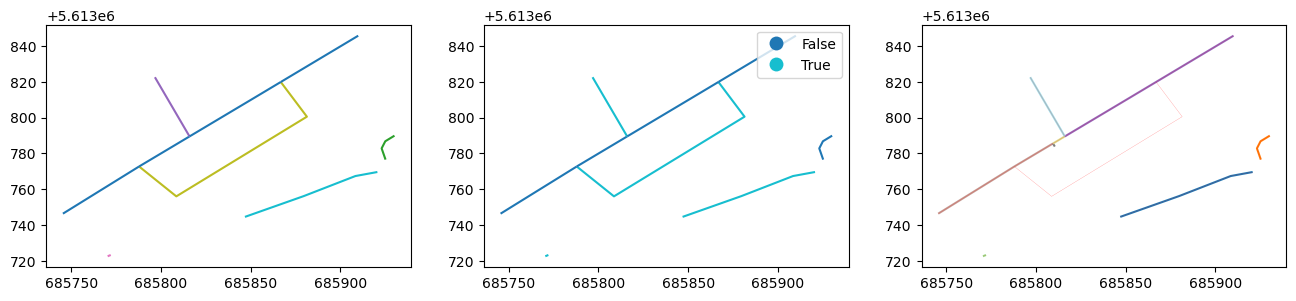

5393


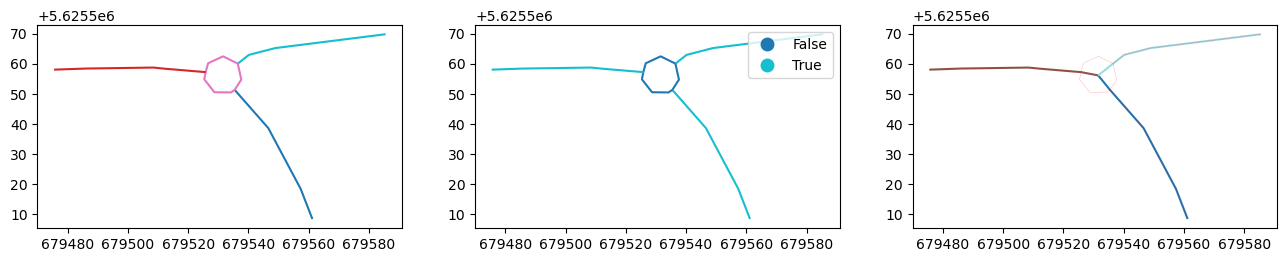

2818


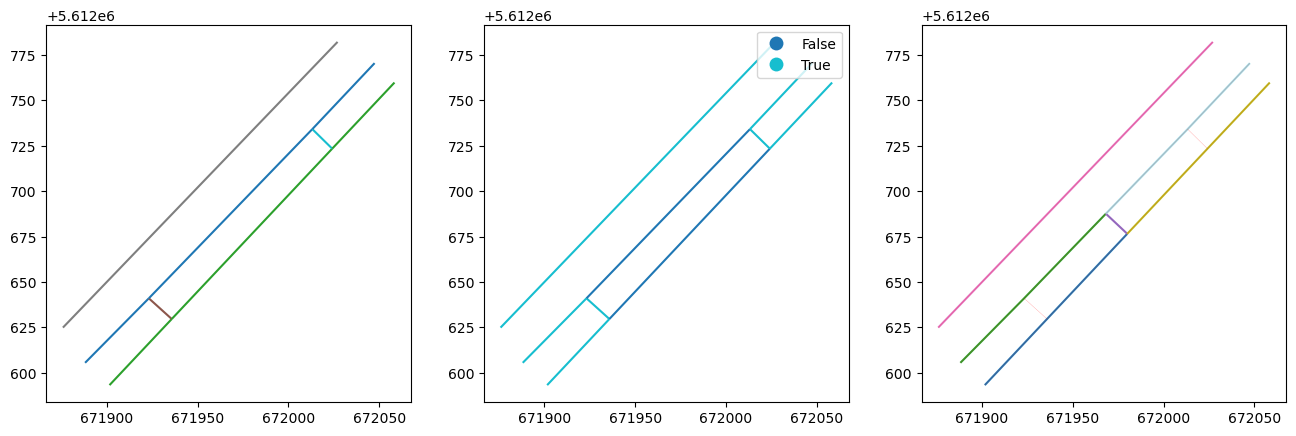

3860


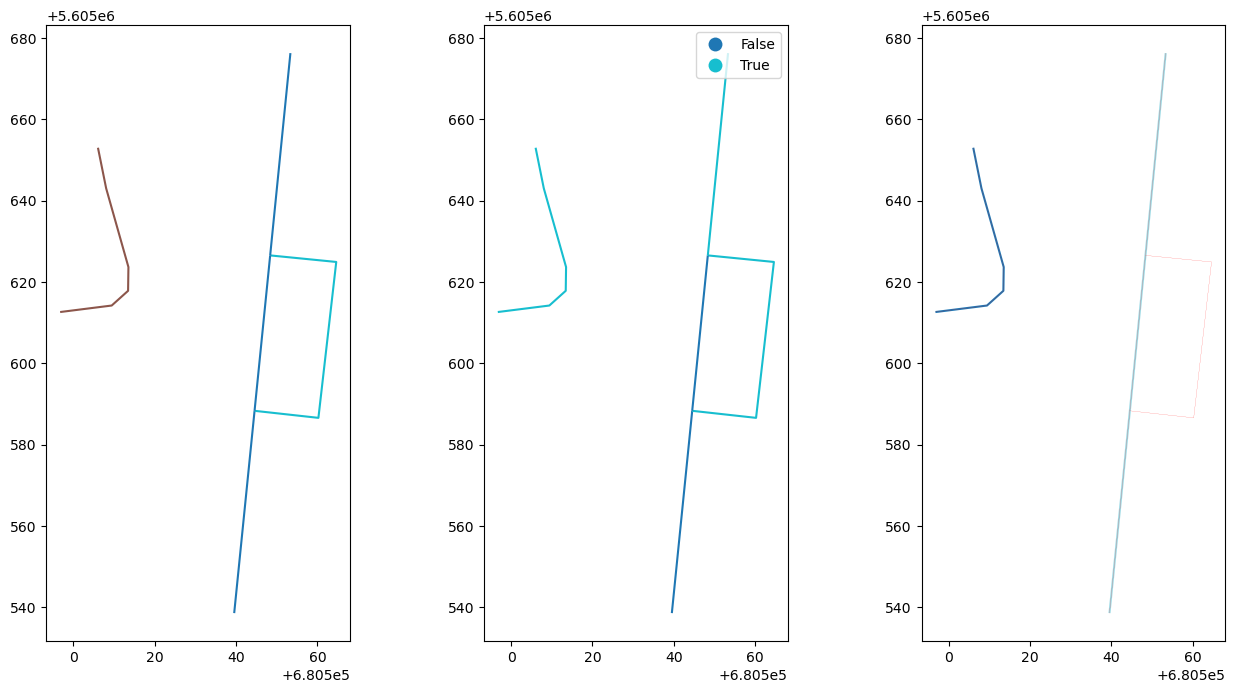

3244


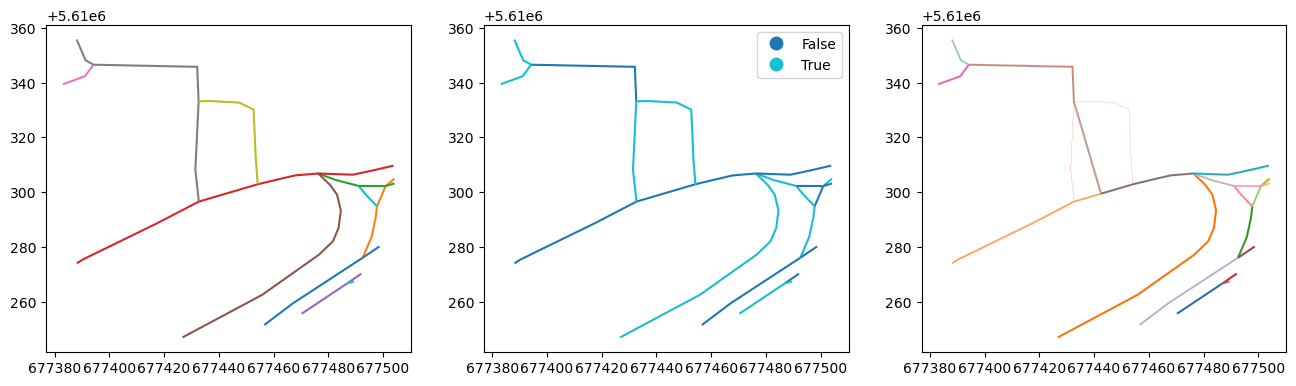

6521


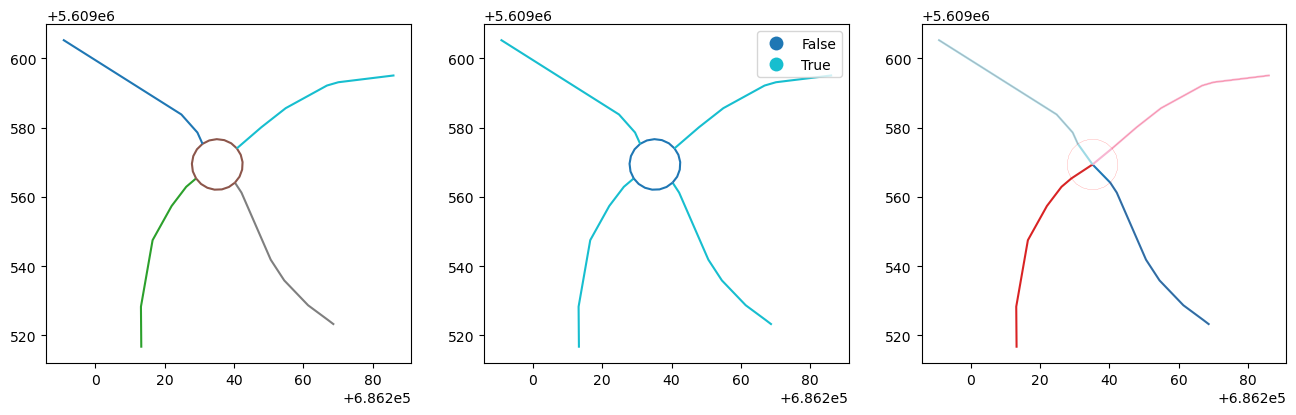

5522


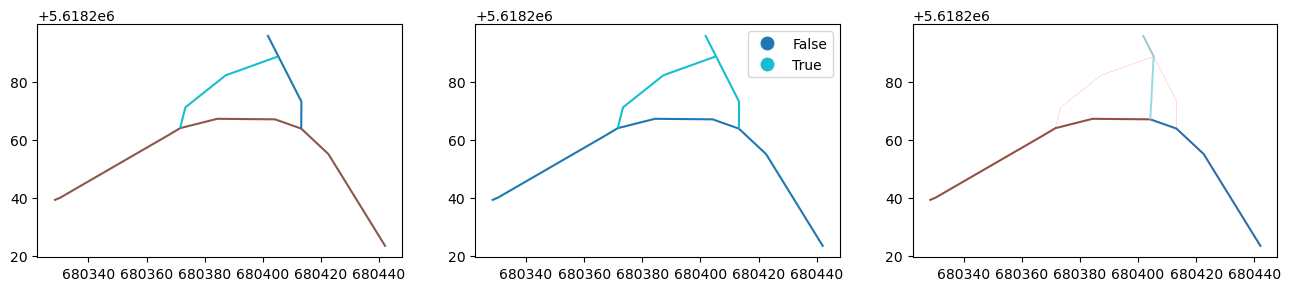

5834


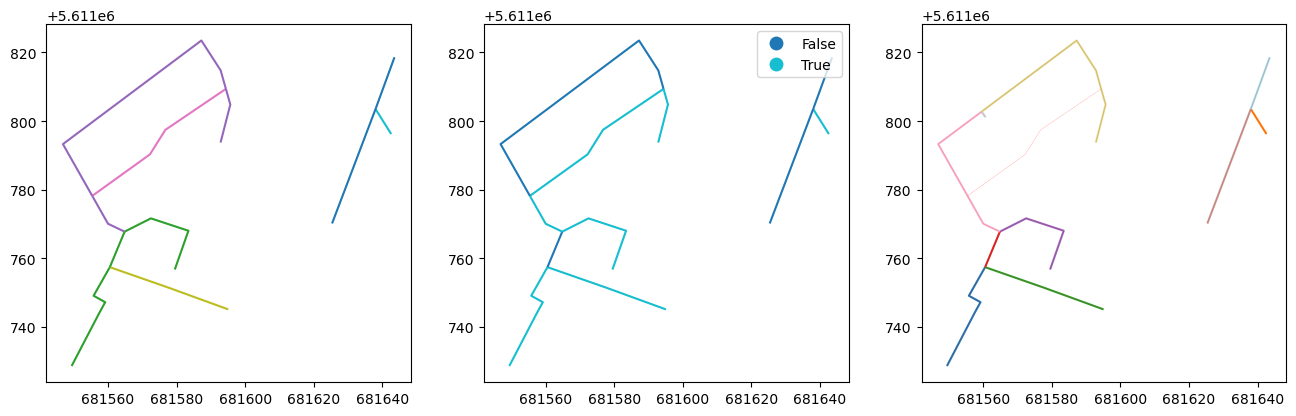

5132


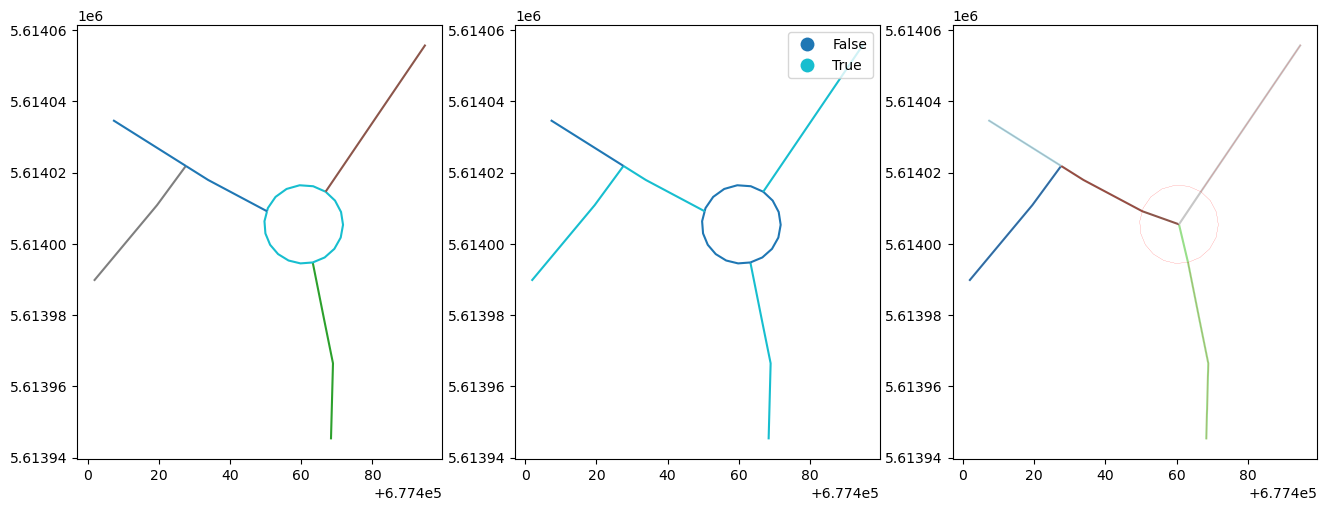

4877


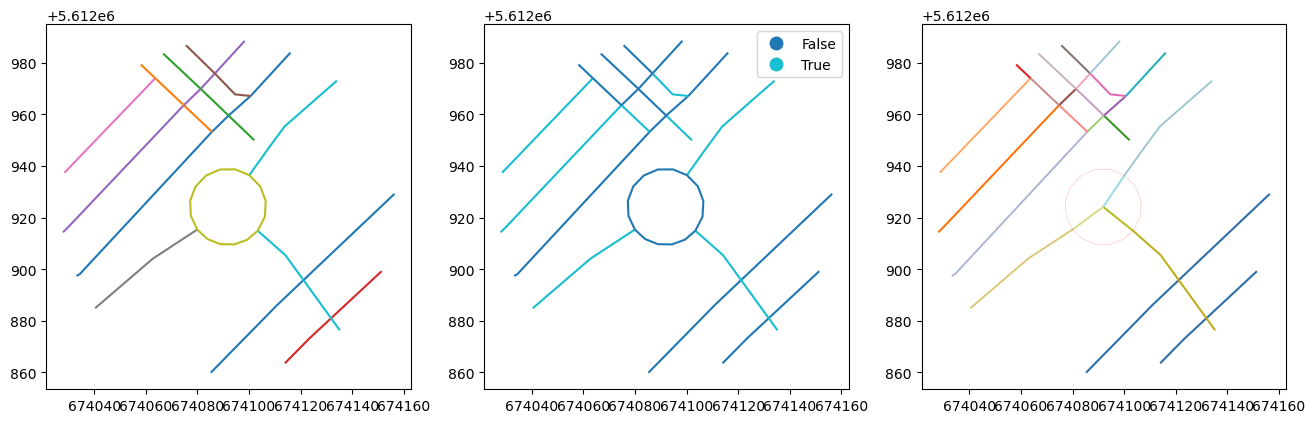

6727


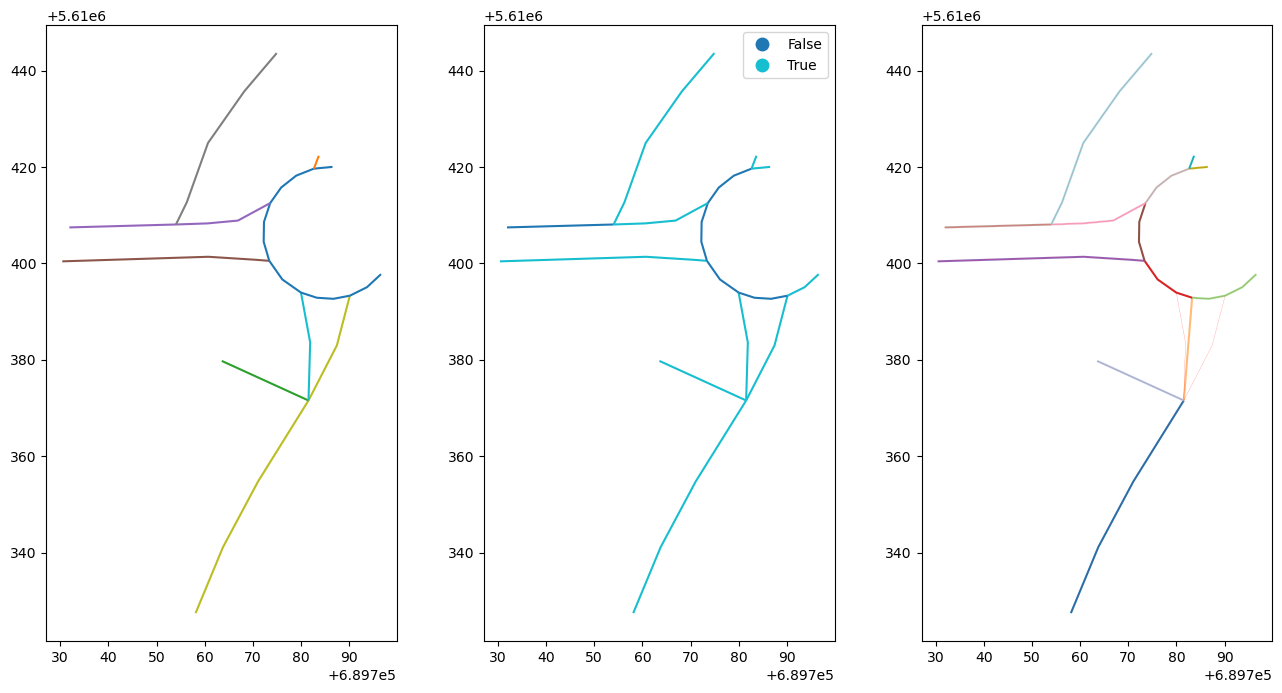

4642


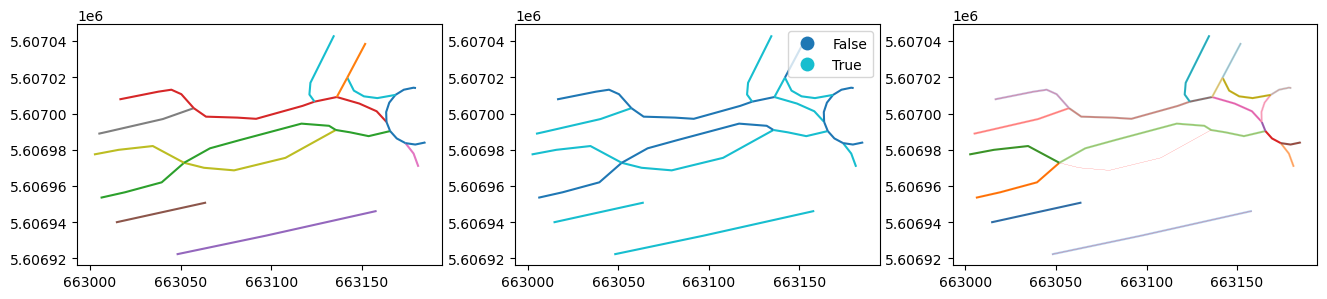

2185


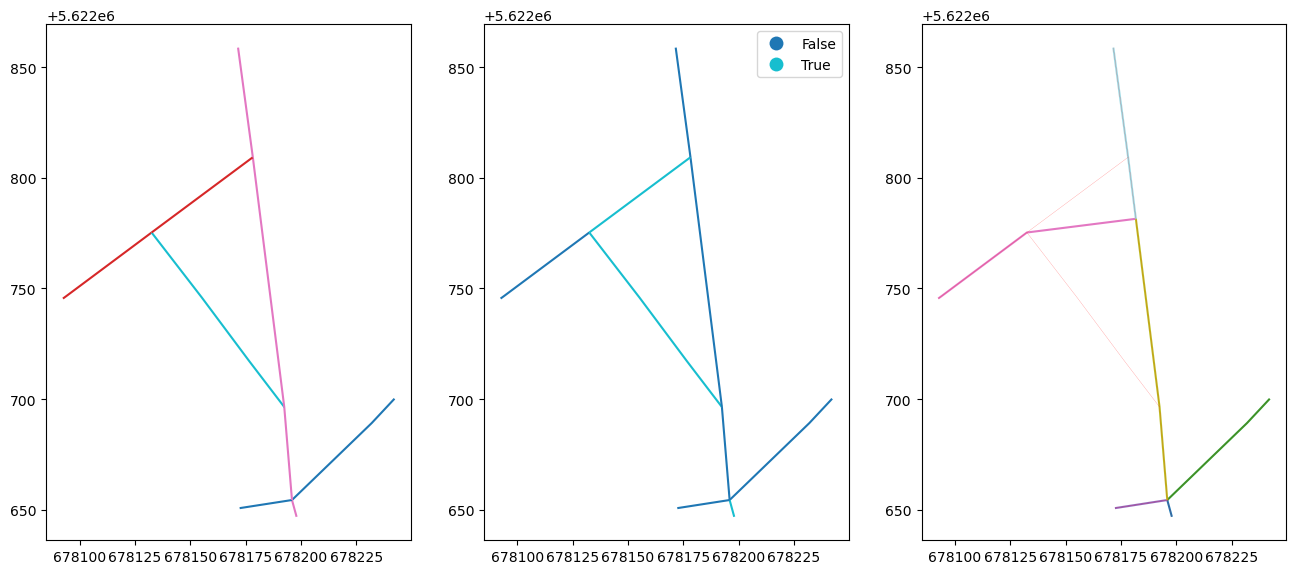

6892


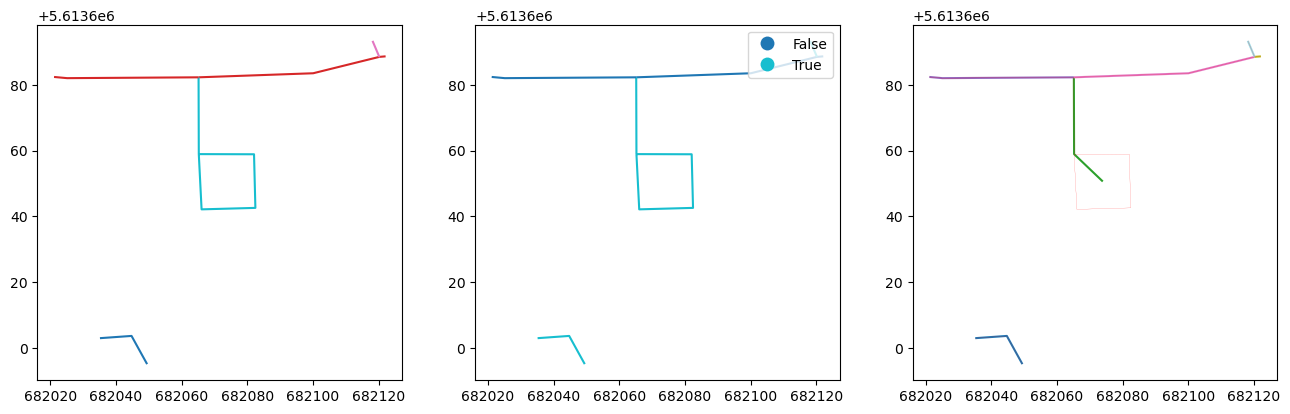

6806


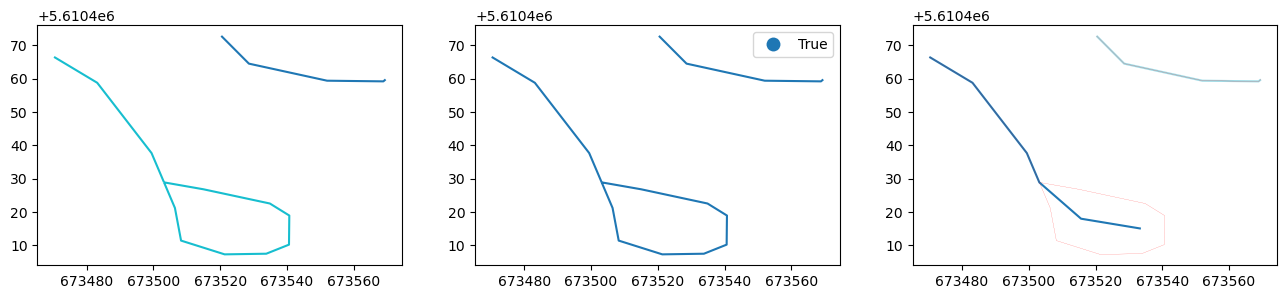

6981


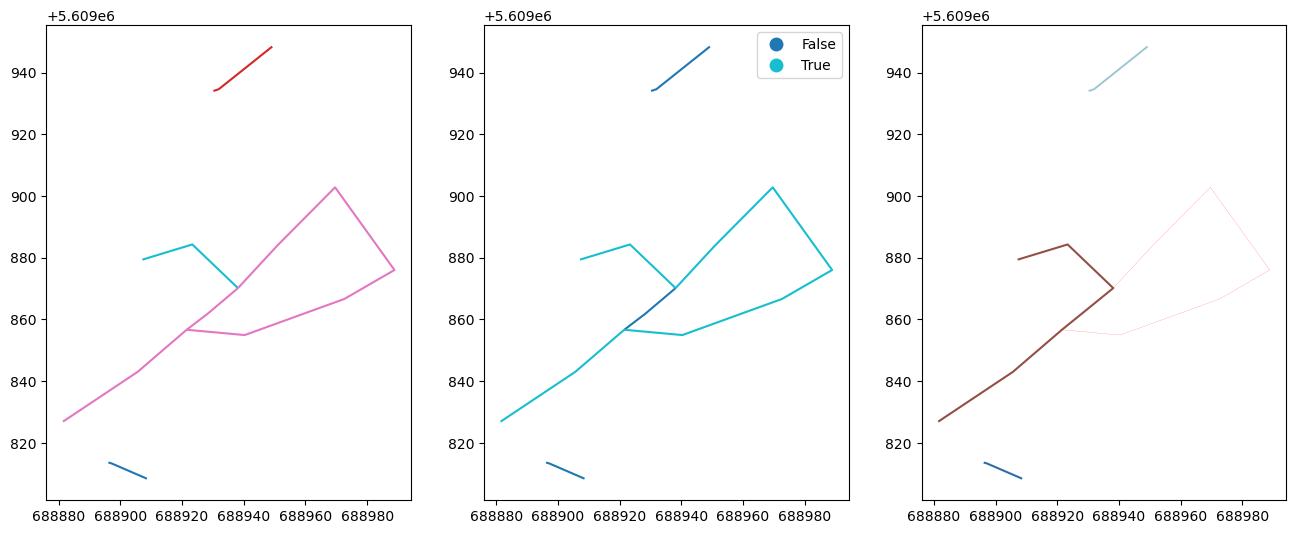

1458


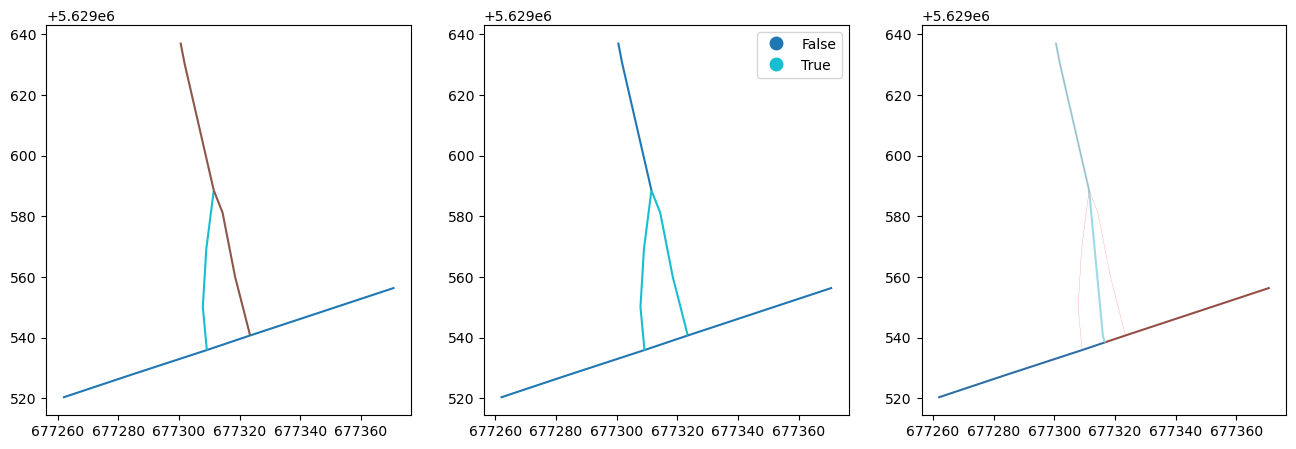

6942


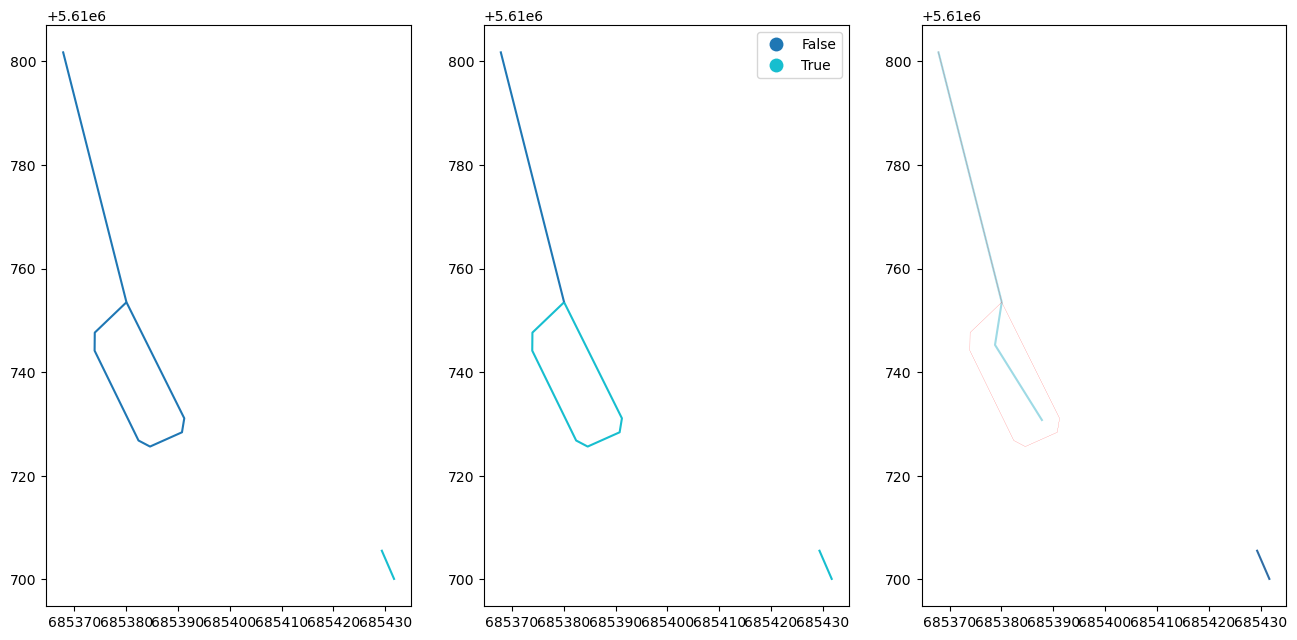

6988


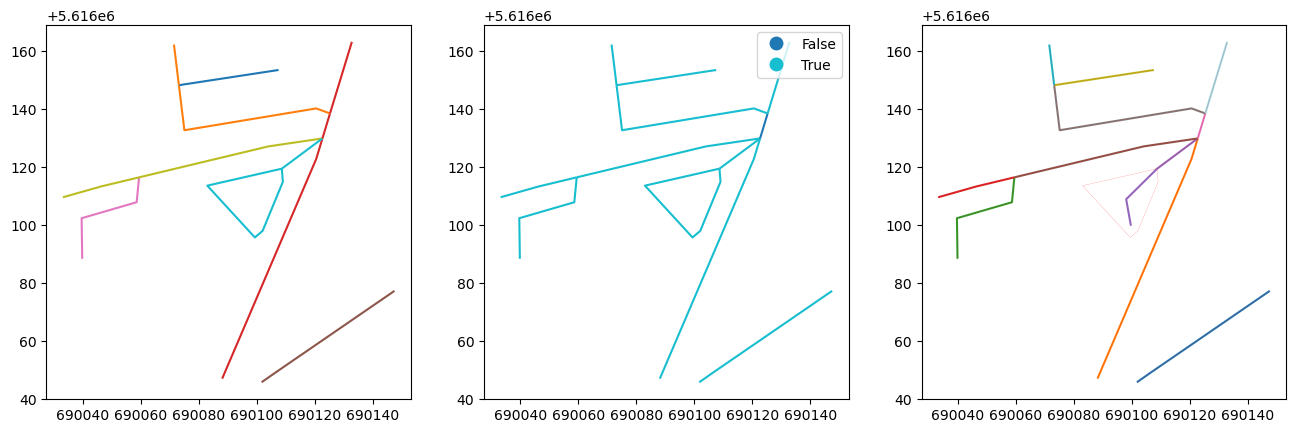

4863


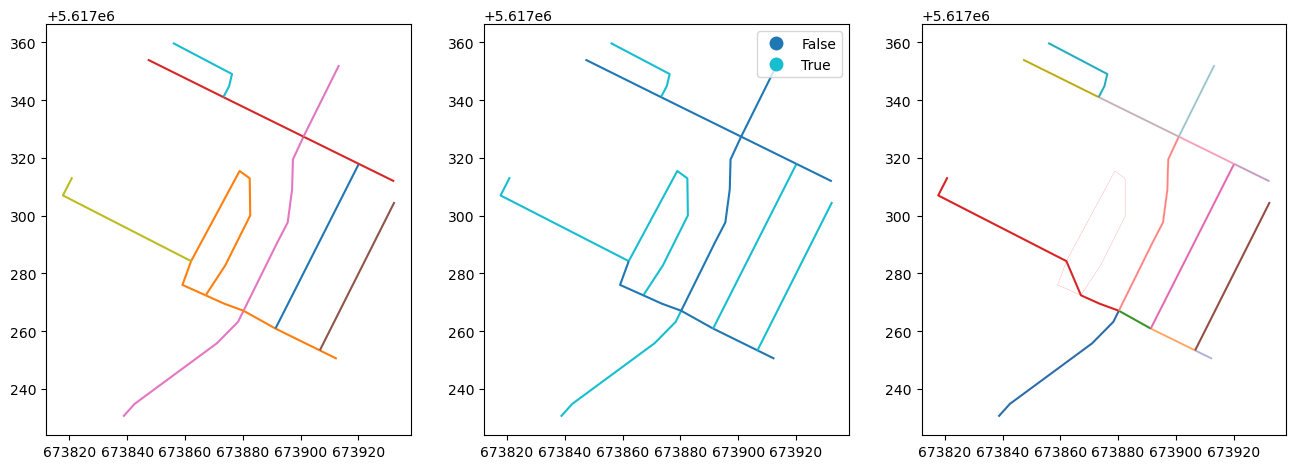

4994


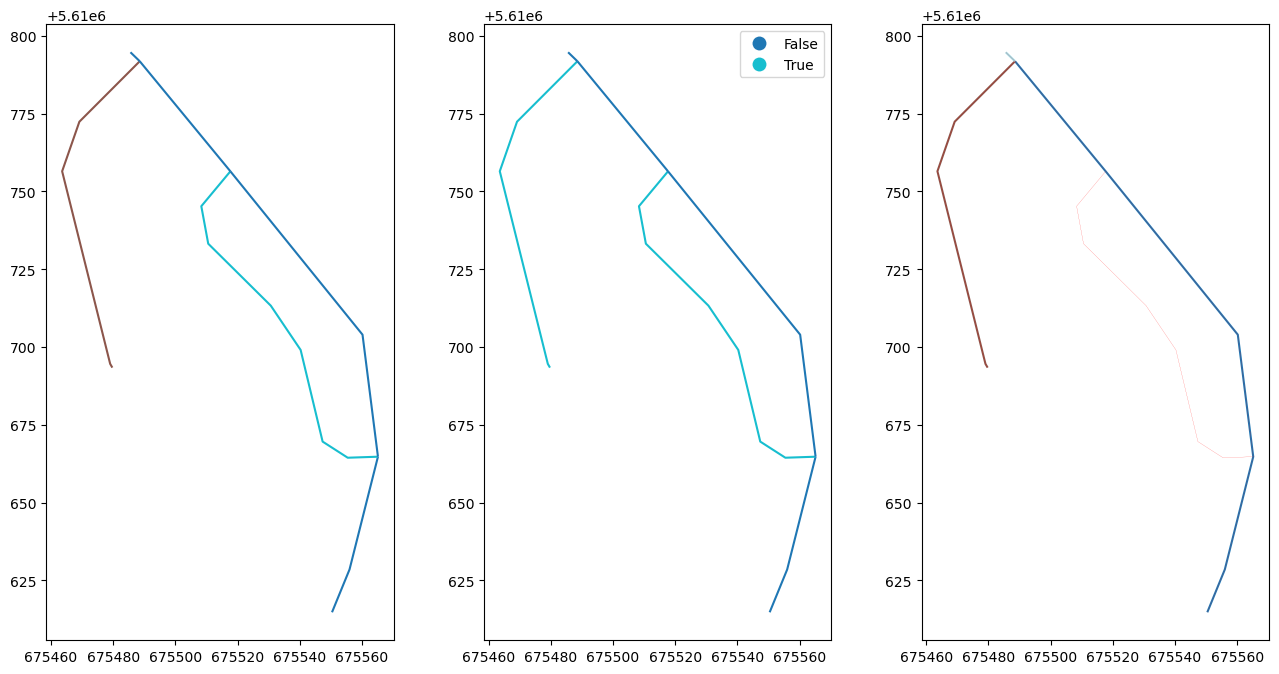

6707


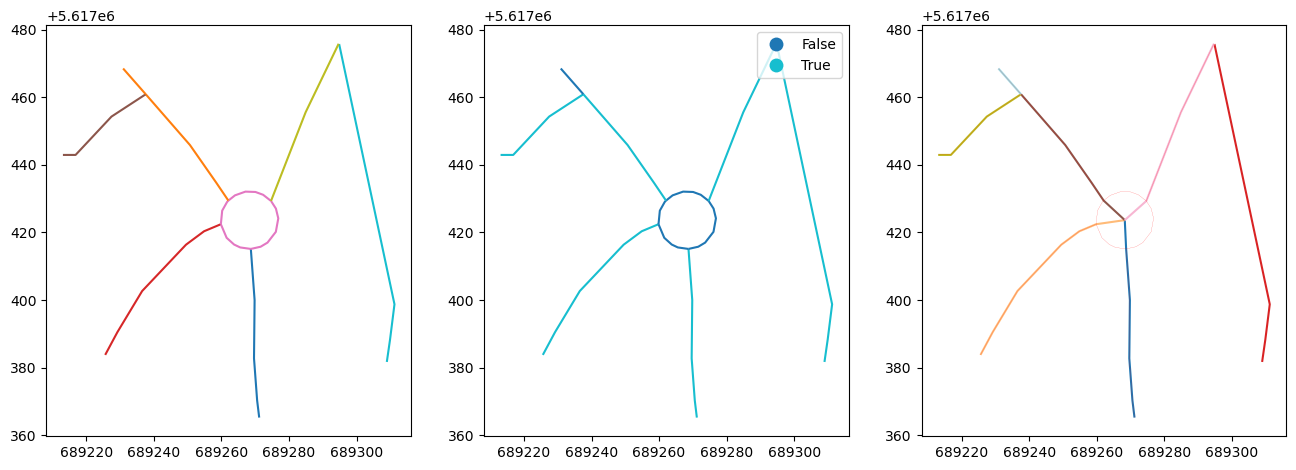

6971


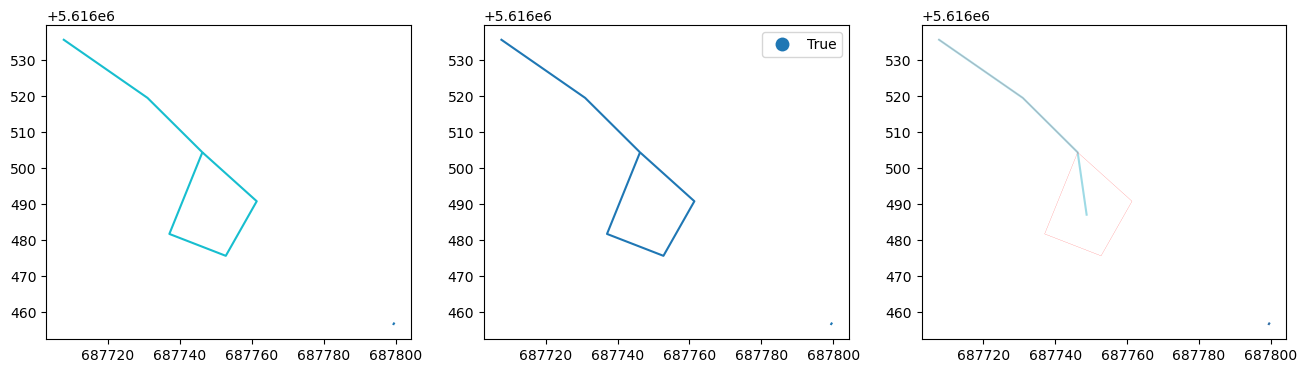

6515


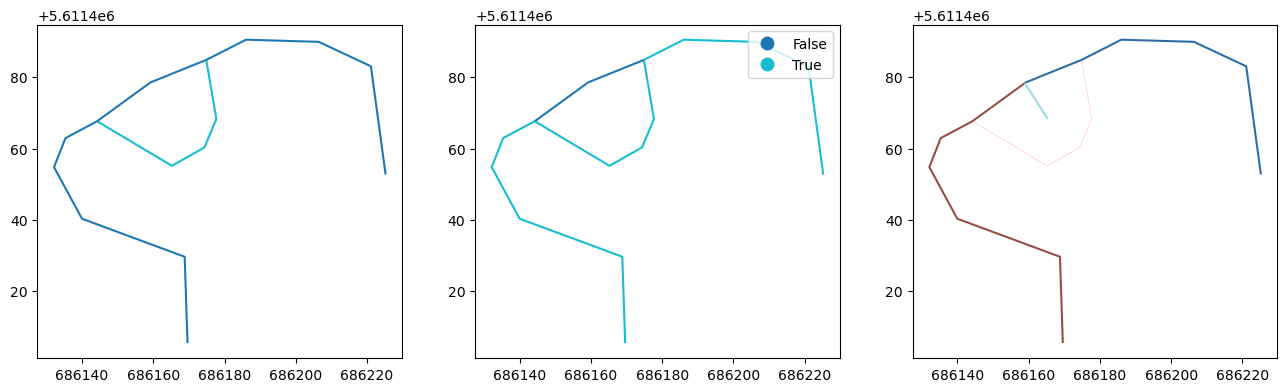

4209


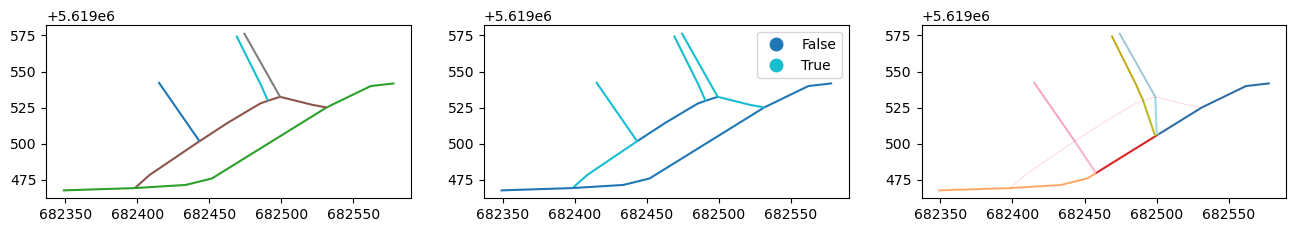

6152


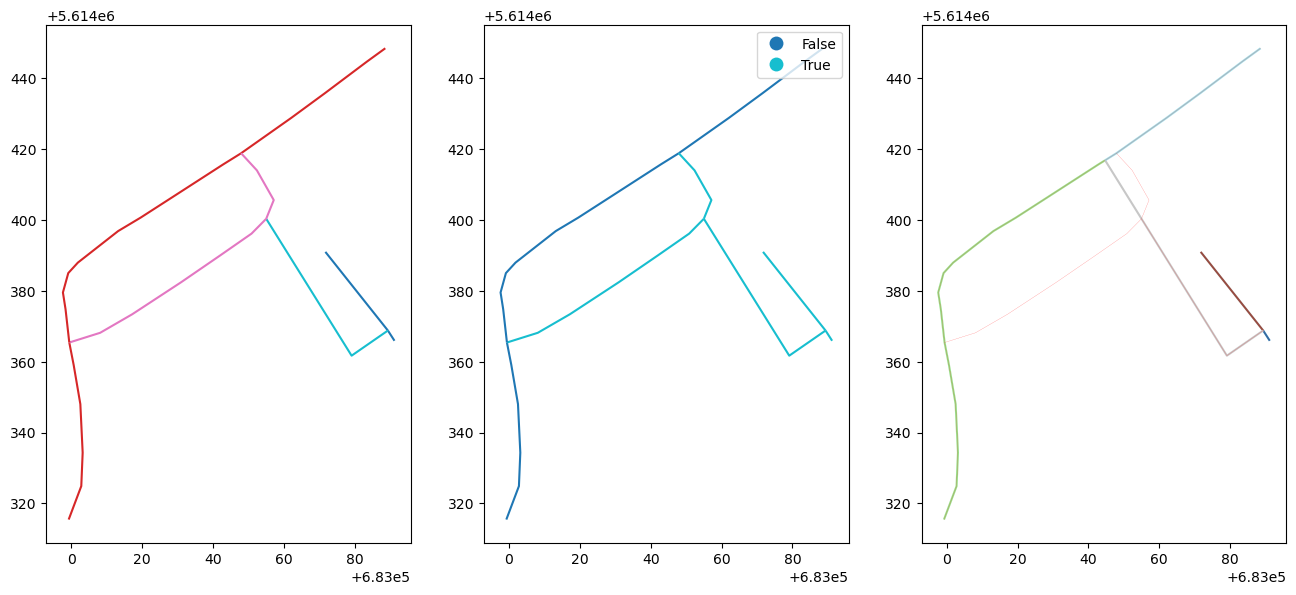

3796


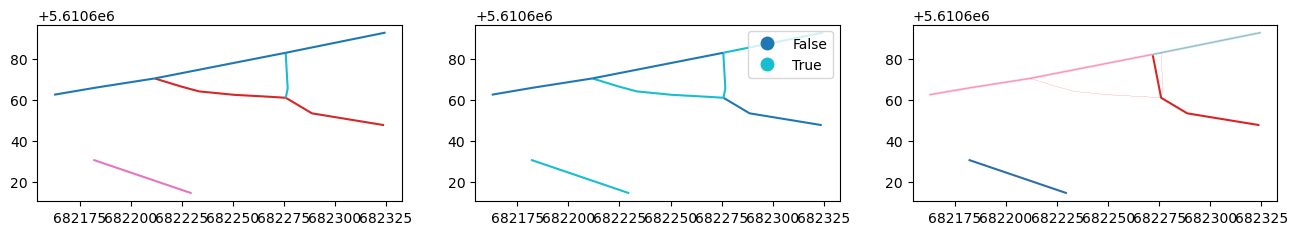

2900


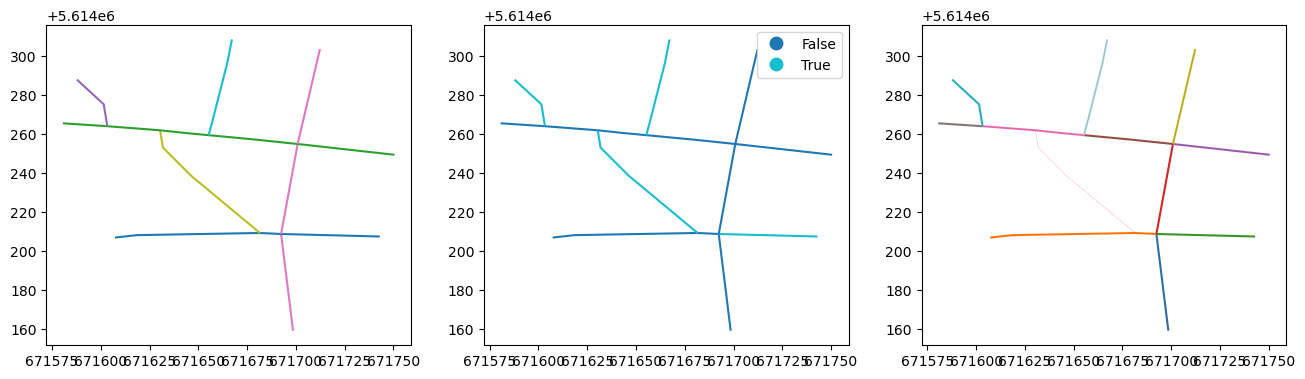

5118


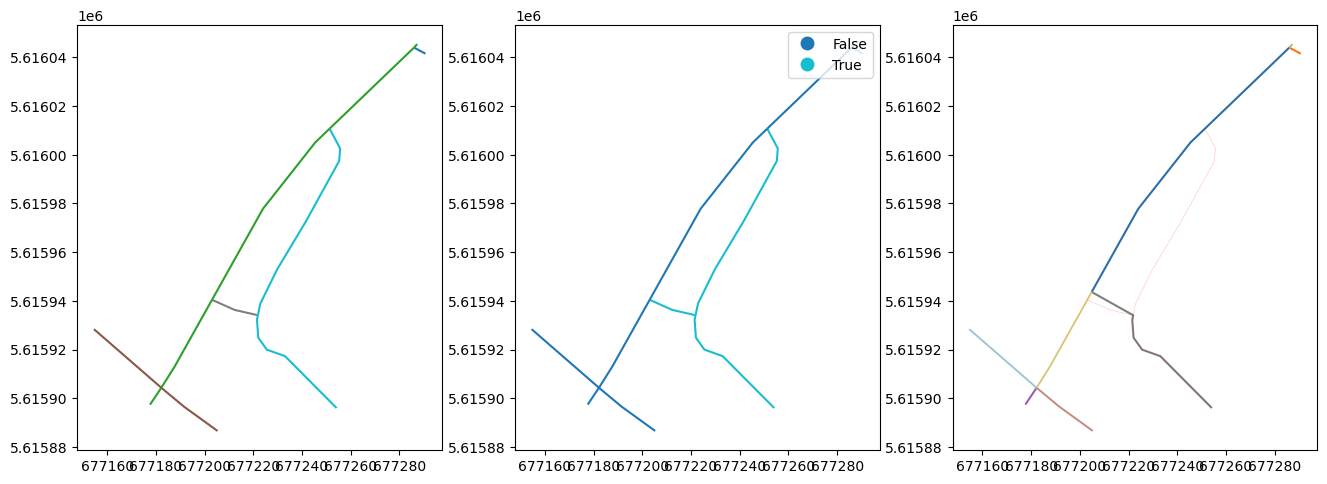

6863


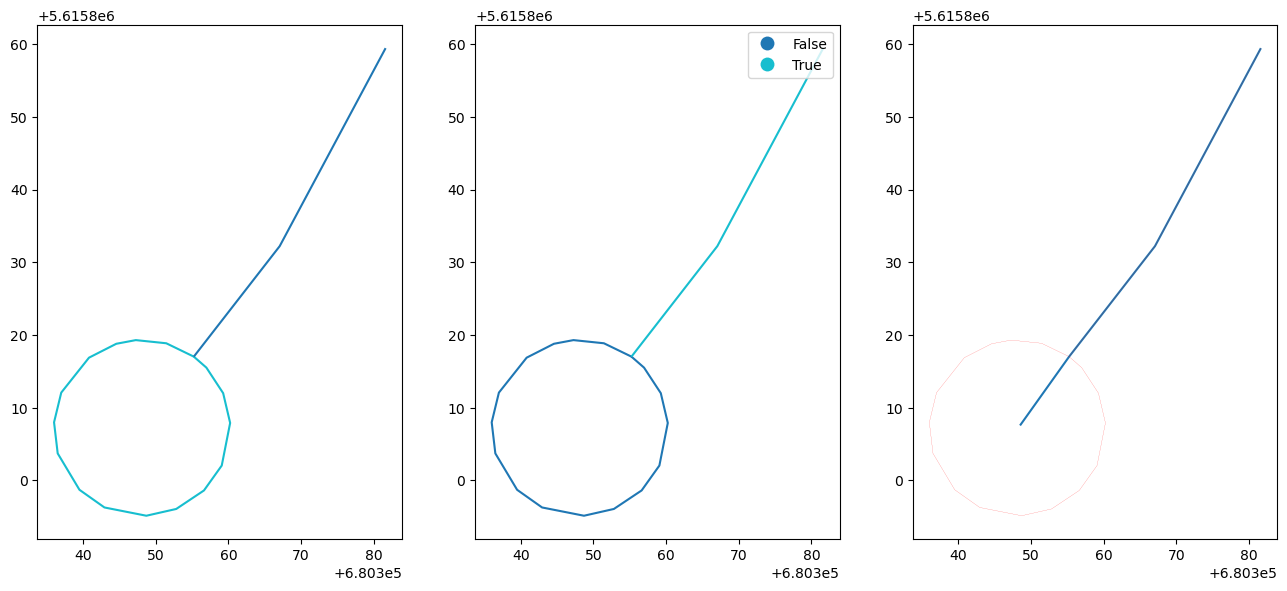

6314


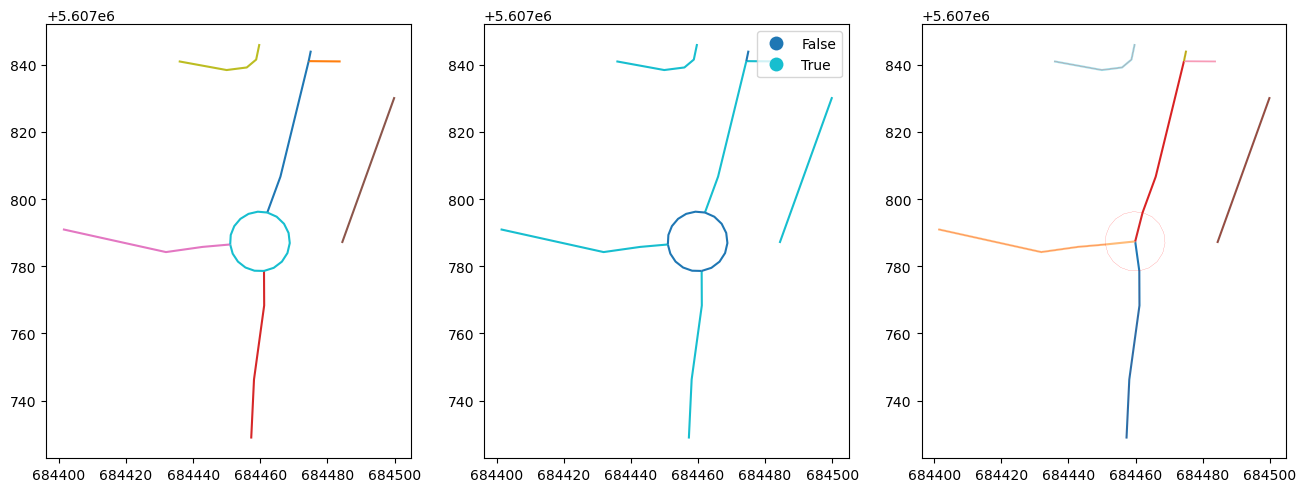

2203


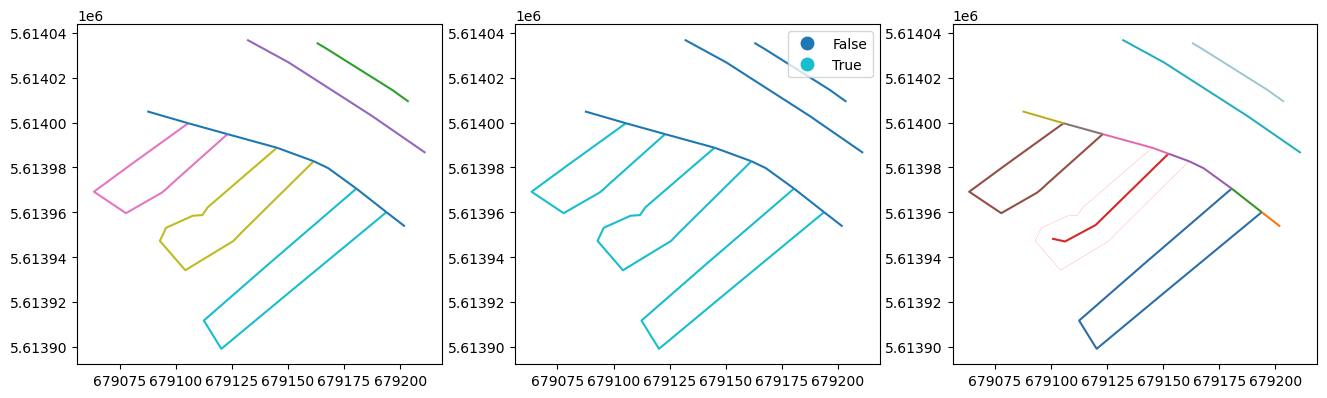

2932


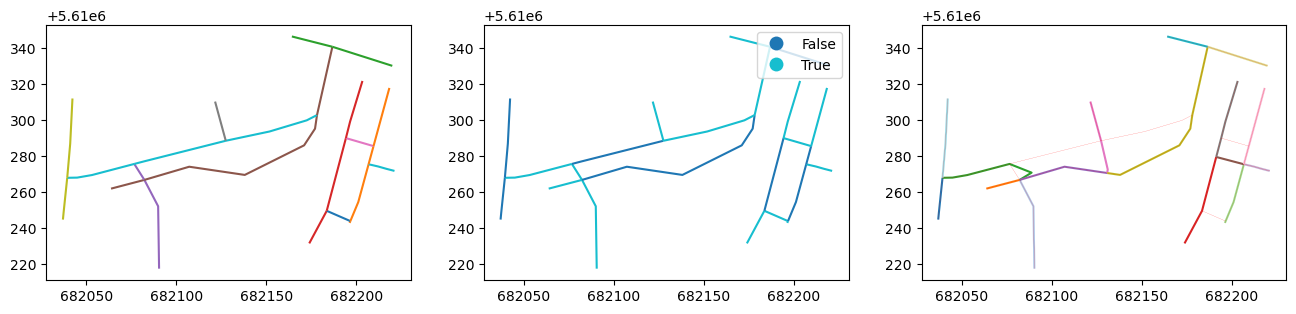

6952


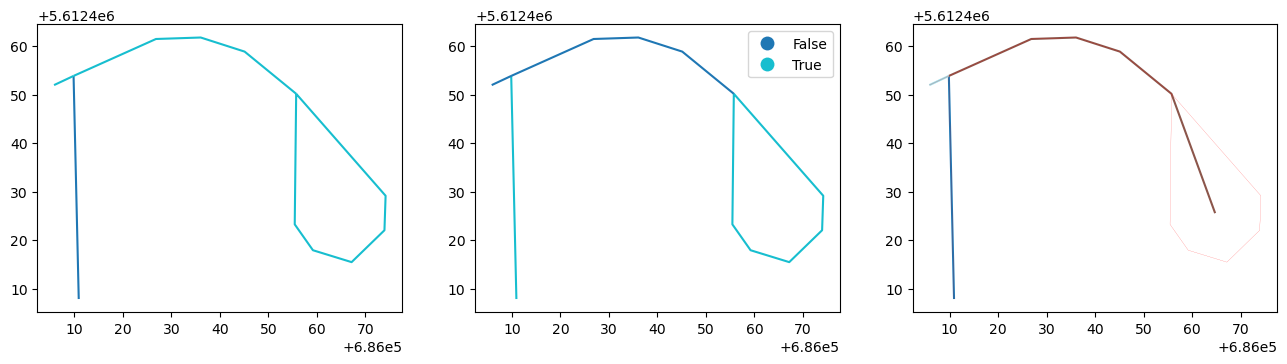

3264


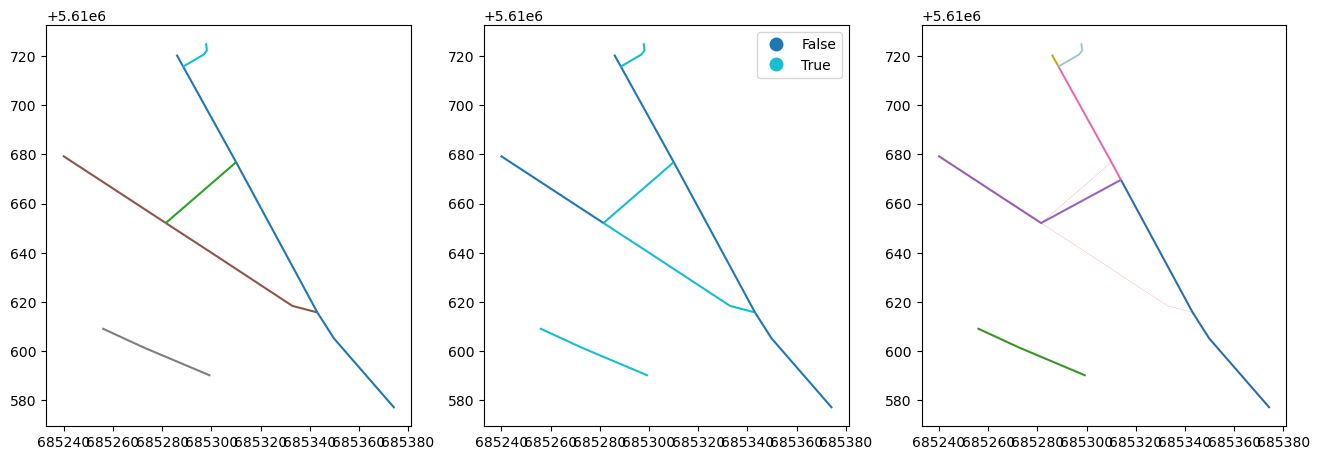

6209


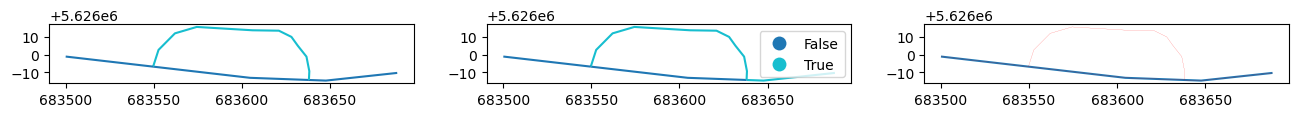

6828


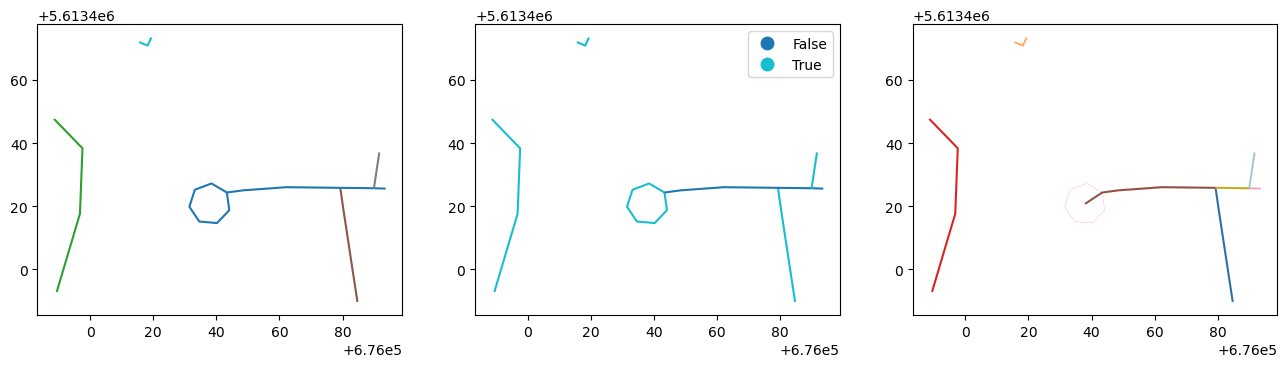

3467


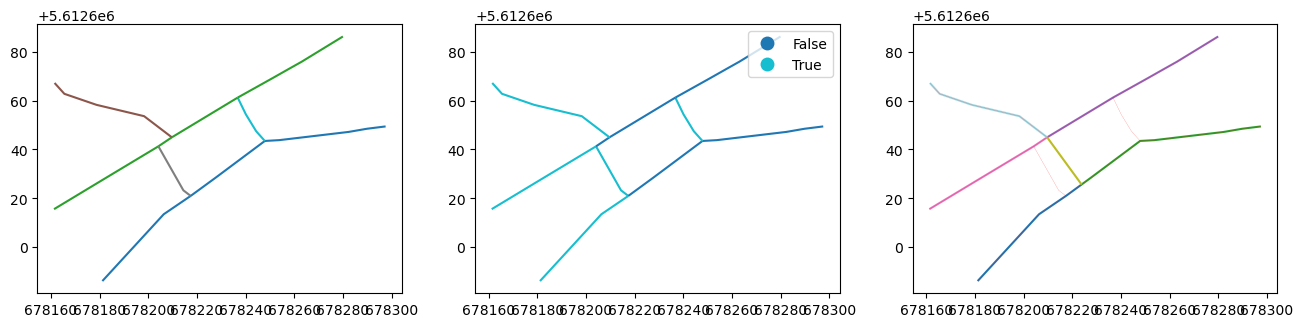

In [20]:
for artifact in data_sample.itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    fig, axs = plt.subplots(1, 3, figsize=(16, 8))
    geom = artifact.geometry
    # geom.plot(hatch="//", ax=axs[0], color="none")
    roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
    # geom.plot(hatch="//", ax=axs[1], color="none")
    roads.clip(geom.buffer(50)).plot(
        "coins_end", ax=axs[1], categorical=True, legend=True
    )
    new_roads.clip(geom.buffer(50)).plot(ax=axs[2], zorder=2, cmap="tab20")
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=axs[2],
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()